In [1]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt

from pyttn import generate_spanning_tree, generate_hierarchical_clustering_tree, convert_nx_to_tree, ntree

from scipy.cluster.hierarchy import dendrogram, linkage

/home/lachlan/pyttn/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


[4, 3, 2, 1, 9, 8, 7, 6, 5, 0]
[0, 6, 1, 5, 3, 8, 2, 7, 4, 9]


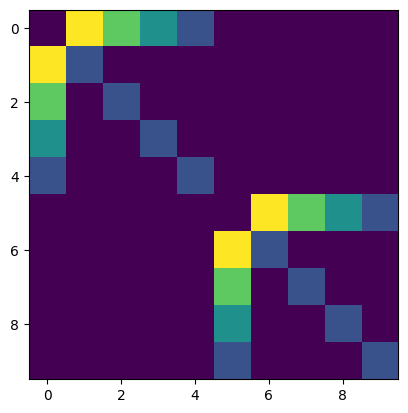

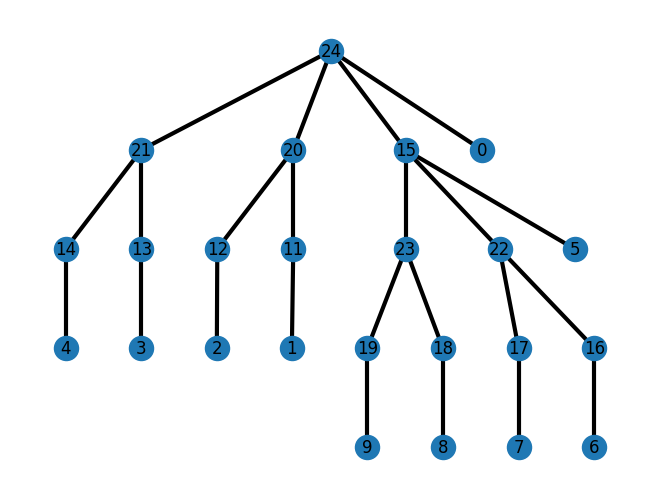

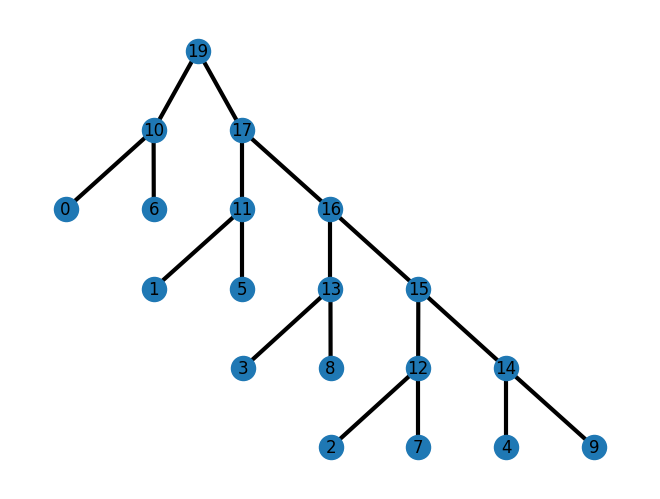

In [28]:
from pyttn.utils import visualise_tree


tree = ntree("(0(121))")
tree2 = ntree("(0(121))")

N=4
M=2
#G = nx.erdos_renyi_graph(N, 0.1)
#gamma = nx.to_numpy_array(G)
v = N-np.arange(N)#np.random.uniform(0, 1, size=N)
w = np.diag(np.ones(N))#np.random.uniform(0, 1, size=(N)))
w = (w + w.T)/2.0
gamma = np.zeros((N+1, N+1))
gamma[0, 1:] = v
gamma[1:, 0] = v
gamma[1:, 1:] = w
gamma += 1e-15

G2 = np.zeros((M*(N+1),M*(N+1)))
for i in range(M):
   G2[i*(N+1):(i+1)*(N+1), i*(N+1):(i+1)*(N+1)]=gamma

for i in range(M-1):
   G2[i*(N+1), (i+1)*(N+1)] = 0.01
   G2[(i+1)*(N+1), i*(N+1)] = 0.01


plt.figure(1)
plt.imshow(G2)

spanning_tree, spanning_root_ind = generate_spanning_tree(G2, max_nchild=1, root_index=0)
clustering_tree, clustering_root_ind = generate_hierarchical_clustering_tree(G2)

tree, leaf_ordering = convert_nx_to_tree(spanning_tree, root_ind=spanning_root_ind)
print(leaf_ordering)
tree2, leaf_ordering2 = convert_nx_to_tree(clustering_tree, root_ind=clustering_root_ind)
print(leaf_ordering2)

plt.figure(2)
visualise_tree(tree, prog='dot')

plt.figure(3)
visualise_tree(tree2, prog='dot')



ntree : (15(11(1)(8(5)(6)))(13(3)(12(9(2)(7))(10(0)(4)))));



{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [35.0, 35.0, 60.0, 60.0],
  [12.5, 12.5, 47.5, 47.5]],
 'dcoord': [[0.0, np.float64(0.0), np.float64(0.0), 0.0],
  [0.0,
   np.float64(1.1547005383792515),
   np.float64(1.1547005383792515),
   np.float64(0.0)],
  [0.0, np.float64(0.0), np.float64(0.0), 0.0],
  [0.0, np.float64(1.0), np.float64(1.0), 0.0],
  [np.float64(0.0),
   np.float64(2.1213203435596424),
   np.float64(2.1213203435596424),
   np.float64(1.0)],
  [0.0,
   np.float64(4.110960958218893),
   np.float64(4.110960958218893),
   np.float64(2.1213203435596424)],
  [np.float64(1.1547005383792515),
   np.float64(14.071839491220281),
   np.float64(14.071839491220281),
   np.float64(4.110960958218893)]],
 'ivl': ['1', '5', '6', '3', '2', '7', '0', '4'],
 'leaves': [1, 5, 6, 3, 2, 7, 0, 4],
 'color_list': ['C1', 'C1', 'C2', 'C2', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1

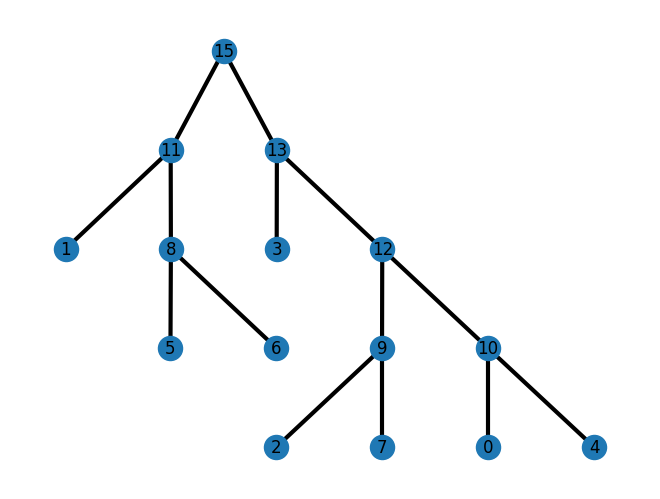

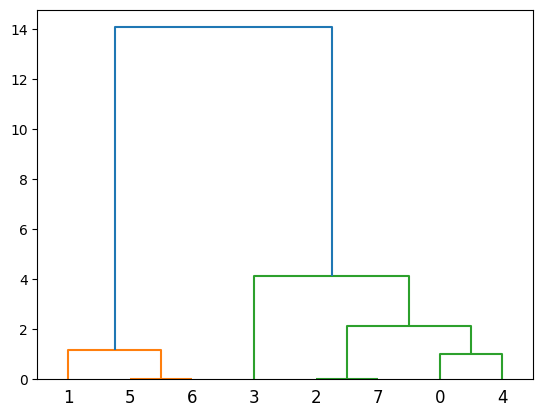

In [29]:
X = [2, 8, 0, 4, 1, 9, 9, 0]
M = np.zeros((len(X)*(len(X)-1))//2)
dist = np.zeros((len(X), len(X)))
c=0
for i in range(len(X)):
   for j in range(i+1,len(X)):
      M[c] = np.abs(X[i]-X[j])
      dist[i, j] = np.abs(X[i]-X[j])
      c=c+1
for i in range(len(X)):
   for j in range(len(X)):
      dist[i, j] = np.abs(X[i]-X[j])
tree, root_ind = generate_hierarchical_clustering_tree(dist)
tree, leaf_ordering = convert_nx_to_tree(tree, root_ind=root_ind)

print(tree)
import networkx as nx
plt.figure(1)
visualise_tree(tree)
plt.figure(2)
Z = linkage(M, method='ward')
dendrogram(Z)